In [3]:
import configparser
import itertools
import os.path as op

CP = configparser.ConfigParser()
CP.read_file(open(op.join(op.expanduser('~'), '.aws', 'credentials')))
CP.sections()
aws_access_key = CP.get('hcp', 'AWS_ACCESS_KEY_ID')
aws_secret_key = CP.get('hcp', 'AWS_SECRET_ACCESS_KEY')

def attach_keys(list_of_arg_lists):
    new_list_of_arg_lists = []
    for args in list_of_arg_lists:
        arg_ls = list(args)
        arg_ls.extend([aws_access_key, aws_secret_key])
        new_list_of_arg_lists.append(arg_ls)
    return new_list_of_arg_lists

In [4]:
def afq_hcp_retest(subject, shell, session, seg_algo, aws_access_key, aws_secret_key):
    import logging
    import packaging # We need to look into this
    import s3fs

    from AFQ.data import fetch_hcp
    import AFQ.api as api
    import AFQ.mask as afm

    logging.basicConfig(level=logging.INFO)
    log = logging.getLogger(__name__)
    
    fs = s3fs.S3FileSystem()


    _, hcp_bids = fetch_hcp(
        [subject],
        profile_name=False,
        study=f"HCP_{session}",
        aws_access_key_id=aws_access_key,
        aws_secret_access_key=aws_secret_key)

    if shell == "single":
        tracking_params = {}
        kwargs = {
            "min_bval": 990,
            "max_bval": 1010
        }
    else:
        tracking_params = {
            'seed_mask': afm.ScalarMask('dki_fa'),
            'stop_mask': afm.ScalarMask('dki_fa'),
            "odf_model": "DKI"}
        kwargs = {
            "scalars": ["dki_fa", "dki_md"]
        }
    
    myafq = api.AFQ(
        hcp_bids,
        brain_mask=afm.LabelledMaskFile('seg', {'scope':'dmriprep'}, exclusive_labels=[0]),
        tracking_params=tracking_params,
        segmentation_params={"seg_algo": seg_algo},
        virtual_frame_buffer=True,
        **kwargs)
    myafq.export_all()
    myafq.upload_to_s3(
        fs,
        f"profile-hcp-west/hcp_reliability/{shell}_shell/hcp_{session.lower()}_{seg_algo}")

In [28]:
all_subjects = [
#     103818,
#     105923,
#     111312,
#     114823,
#     115320,
#     122317,
#     125525,
#     130518,
#     135528,
#     137128,
#     139839,
#     143325,
#     144226,
#     146129,
#     149337,
#     149741,
#     151526,
#     158035,
#     169343,
#     172332,
#     175439,
#     177746,
#     185442,
#     187547,
#     192439,
#     194140,
#     195041,
#     200109,
#     200614,
#     204521,
#     250427,
#     287248,
#     341834,
#     433839,
#     562345,
#     599671,
#     601127,
#     627549,
#     660951,
    662551, #TODO: this one didnt go through
#     783462,
#     859671,
#     861456,
#     877168,
#     917255
]

In [29]:
subjects = [str(i) for i in all_subjects] 
shell = ["single", "multi"]
session = ["1200", "Retest"]
seg_algo = ["afq"]#, "reco"]


args = list(itertools.product(subjects, shell, session, seg_algo))
print(args)
args = attach_keys(args)

[('662551', 'single', '1200', 'afq'), ('662551', 'single', 'Retest', 'afq'), ('662551', 'multi', '1200', 'afq'), ('662551', 'multi', 'Retest', 'afq')]


In [30]:
#afq_hcp_retest(*args[1])

In [31]:
#afq_hcp_retest(attach_keys(['169343'])[0])

In [32]:
import cloudknot as ck
ck.set_region('us-west-2')

In [33]:
knot = ck.Knot(name='hcp_api-64gb-20914-0',
              func=afq_hcp_retest,
              base_image='libglxvfb:1',
              image_github_installs="https://github.com/yeatmanlab/pyAFQ.git#egg=pyAFQ[fury]",
              pars_policies=('AmazonS3FullAccess',),
              bid_percentage=100,
              volume_size=64,
              memory=64000) #TODO increase vcpu amount

In [34]:
result_futures = knot.map(args, starmap=True)

In [35]:
ck.set_region('us-west-2')
knot.view_jobs()

Job ID              Name                        Status   
---------------------------------------------------------
8125aca5-7c29-4473-a20b-0f293e2c1274        hcp-api-64gb-20914-0-0        SUBMITTED


In [107]:
j0 = knot.jobs[0]
j0.status


{'status': 'PENDING',
 'statusReason': None,
 'attempts': [],
 'arrayProperties': {'statusSummary': {'STARTING': 0,
   'FAILED': 140,
   'RUNNING': 30,
   'SUCCEEDED': 112,
   'RUNNABLE': 78,
   'SUBMITTED': 0,
   'PENDING': 0},
  'size': 360}}

In [40]:
knot.clobber(clobber_pars=True, clobber_repo=True, clobber_image=True)

In [8]:
import AFQ.api as api
from importlib import reload
reload(api)

/home/john/miniconda3/envs/afq/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<module 'AFQ.api' from '/home/john/pyAFQ/AFQ/api.py'>

In [9]:
api.download_and_combine_afq_profiles(
    "~/hcp_reliability_profiles/single_shell_test_profiles.csv",
    "profile-hcp-west",
    "hcp_reliability/single_shell/hcp_1200_afq"
    )
api.download_and_combine_afq_profiles(
    "~/hcp_reliability_profiles/single_shell_retest_profiles.csv",
    "profile-hcp-west",
    "hcp_reliability/single_shell/hcp_retest_afq"
    )
# api.download_and_combine_afq_profiles(
#     "~/hcp_reliability_profiles/single_shell_test_reco_profiles.csv",
#     "profile-hcp-west",
#     "hcp_reliability/single_shell/hcp_1200_reco"
#     )
# api.download_and_combine_afq_profiles(
#     "~/hcp_reliability_profiles/single_shell_retest_reco_profiles.csv",
#     "profile-hcp-west",
#     "hcp_reliability/single_shell/hcp_retest_reco"
#     )

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


Retrieving subject S3 keys
[                                        ] | 0% Completed |  0.0s

/home/john/miniconda3/envs/afq/lib/python3.7/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[                                        ] | 0% Completed |  0.1s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[                                        ] | 0% Completed |  0.8s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[##                                      ] | 6% Completed |  0.9s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[####                                    ] | 11% Completed |  1.1s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[#####                                   ] | 13% Completed |  1.3s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[#######                                 ] | 18% Completed |  1.6s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[########                                ] | 20% Completed |  1.8s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[############                            ] | 31% Completed |  1.9s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[##############                          ] | 36% Completed |  2.3s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[###############                         ] | 38% Completed |  2.5s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[#################                       ] | 43% Completed |  2.6s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[#################                       ] | 43% Completed |  2.8s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[######################                  ] | 56% Completed |  3.2s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[#######################                 ] | 59% Completed |  3.5s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[##########################              ] | 65% Completed |  3.7s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[#############################           ] | 72% Completed |  3.9s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[###############################         ] | 79% Completed |  4.3s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[################################        ] | 81% Completed |  4.5s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[########################################] | 100% Completed |  5.2s


Retrieving subject S3 keys
[                                        ] | 0% Completed |  0.0s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[                                        ] | 0% Completed |  0.7s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[                                        ] | 2% Completed |  0.8s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[###                                     ] | 8% Completed |  1.0s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[#######                                 ] | 17% Completed |  1.1s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[#######                                 ] | 17% Completed |  1.5s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[########                                ] | 22% Completed |  1.6s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[#########                               ] | 24% Completed |  1.9s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[##############                          ] | 35% Completed |  2.3s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[################                        ] | 40% Completed |  2.5s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[####################                    ] | 51% Completed |  2.9s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[#####################                   ] | 53% Completed |  3.4s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[########################                ] | 62% Completed |  3.6s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[##########################              ] | 66% Completed |  3.8s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[################################        ] | 80% Completed |  4.4s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[################################        ] | 80% Completed |  4.5s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[########################################] | 100% Completed |  5.4s


,Unnamed: 0,bundle,node,dti_fa,dti_md,subjectID,sessionID
0,0,ATR_R,0,0.215723,0.000888,103818,01
1,1,ATR_R,1,0.285697,0.000863,103818,01
2,2,ATR_R,2,0.336204,0.000854,103818,01
3,3,ATR_R,3,0.371903,0.000845,103818,01
4,4,ATR_R,4,0.395845,0.000837,103818,01
...,...,...,...,...,...,...,...
1795,1795,FP,95,0.475840,0.000746,917255,01
1796,1796,FP,96,0.485995,0.000752,917255,01
1797,1797,FP,97,0.433009,0.000741,917255,01
1798,1798,FP,98,0.322908,0.000717,917255,01


In [10]:
api.download_and_combine_afq_profiles(
    "~/hcp_reliability_profiles/multi_shell_test_profiles.csv",
    "profile-hcp-west",
    "hcp_reliability/multi_shell/hcp_1200_afq"
    )
api.download_and_combine_afq_profiles(
    "~/hcp_reliability_profiles/multi_shell_retest_profiles.csv",
    "profile-hcp-west",
    "hcp_reliability/multi_shell/hcp_retest_afq"
    )
# api.download_and_combine_afq_profiles(
#     "~/hcp_reliability_profiles/multi_shell_test_reco_profiles.csv",
#     "profile-hcp-west",
#     "hcp_reliability/multi_shell/hcp_1200_reco"
#     )
# api.download_and_combine_afq_profiles(
#     "~/hcp_reliability_profiles/multi_shell_retest_recoswarm plots_profiles.csv",
#     "profile-hcp-west",
#     "hcp_reliability/multi_shell/hcp_retest_reco"
#     )

Retrieving subject S3 keys
[                                        ] | 0% Completed |  0.0s

/home/john/miniconda3/envs/afq/lib/python3.7/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botoc

[#                                       ] | 4% Completed |  1.0s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[######                                  ] | 15% Completed |  1.1s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[########                                ] | 20% Completed |  1.7s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[##########                              ] | 27% Completed |  1.8s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[##############                          ] | 36% Completed |  2.0s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[###############                         ] | 38% Completed |  2.4s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[################                        ] | 40% Completed |  2.5s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[###################                     ] | 47% Completed |  2.9s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[#####################                   ] | 54% Completed |  3.1s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[########################                ] | 61% Completed |  3.3s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[########################                ] | 61% Completed |  3.6s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[##########################              ] | 65% Completed |  3.8s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[##############################          ] | 75% Completed |  3.9s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[###############################         ] | 79% Completed |  4.0s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[###############################         ] | 79% Completed |  4.2s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[########################################] | 100% Completed |  5.2s


Retrieving subject S3 keys
[                                        ] | 0% Completed |  0.0s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[                                        ] | 0% Completed |  0.2s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[                                        ] | 0% Completed |  1.2s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[####                                    ] | 11% Completed |  1.4s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[#######                                 ] | 17% Completed |  2.2s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[########                                ] | 22% Completed |  2.3s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[############                            ] | 31% Completed |  2.4s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[##############                          ] | 35% Completed |  2.9s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[################                        ] | 40% Completed |  3.2s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[#################                       ] | 44% Completed |  3.3s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[####################                    ] | 51% Completed |  3.5s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[#####################                   ] | 53% Completed |  3.7s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[######################                  ] | 55% Completed |  4.0s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[########################                ] | 62% Completed |  4.2s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[##########################              ] | 66% Completed |  4.3s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[############################            ] | 71% Completed |  4.6s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[#############################           ] | 73% Completed |  4.8s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[###############################         ] | 77% Completed |  5.1s

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[########################################] | 100% Completed |  5.7s


,Unnamed: 0,bundle,node,dki_fa,dki_md,subjectID,sessionID
0,0,ATR_R,0,0.216368,0.001005,103818,01
1,1,ATR_R,1,0.292082,0.000989,103818,01
2,2,ATR_R,2,0.355820,0.000994,103818,01
3,3,ATR_R,3,0.397117,0.000986,103818,01
4,4,ATR_R,4,0.426699,0.000971,103818,01
...,...,...,...,...,...,...,...
1795,1795,FP,95,0.415432,0.000831,917255,01
1796,1796,FP,96,0.441252,0.000842,917255,01
1797,1797,FP,97,0.443114,0.000830,917255,01
1798,1798,FP,98,0.304794,0.000827,917255,01


In [16]:
import AFQ.viz.utils as vut
import logging
single_comparisons = vut.LongitudinalCSVComparison(
    'hcp_reliability_profiles/comparisons',
    [
        "~/hcp_reliability_profiles/single_shell_test_profiles.csv",
        "~/hcp_reliability_profiles/single_shell_retest_profiles.csv",
#         "~/hcp_reliability_profiles/single_shell_test_reduced_profiles.csv",
#         "~/hcp_reliability_profiles/single_shell_retest_reduced_profiles.csv"
    ],
    ['single_test', 'single_retest'],#, 'single_test_reduced', 'single_retest_reduced'],
    subjects=all_subjects)
multi_comparisons = vut.LongitudinalCSVComparison(
    'hcp_reliability_profiles/comparisons',
    [
        "~/hcp_reliability_profiles/multi_shell_test_profiles.csv",
        "~/hcp_reliability_profiles/multi_shell_retest_profiles.csv",
#         "~/hcp_reliability_profiles/multi_shell_test_reco_profiles.csv",
#         "~/hcp_reliability_profiles/multi_shell_retest_reco_profiles.csv"
    ],
    ['multi_test', 'multi_retest'],#, 'multi_test_reduced', 'multi_retest_reduced'],
    subjects=all_subjects,
    scalar_bounds={'lb': {'dki_fa': 0.2},
                   'ub': {'dki_md': 0.002}})

single_comparisons.logger.setLevel(logging.WARNING)
multi_comparisons.logger.setLevel(logging.WARNING)

In [17]:
#print(single_comparisons.profile_dict)

/home/john/pyAFQ/AFQ/viz/utils.py:937: RuntimeWarning: Mean of empty slice
  all_sub_means[m, k] = np.nanmean(bundle_profiles, axis=2)


(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff60d70c9d0>,
       dtype=object))

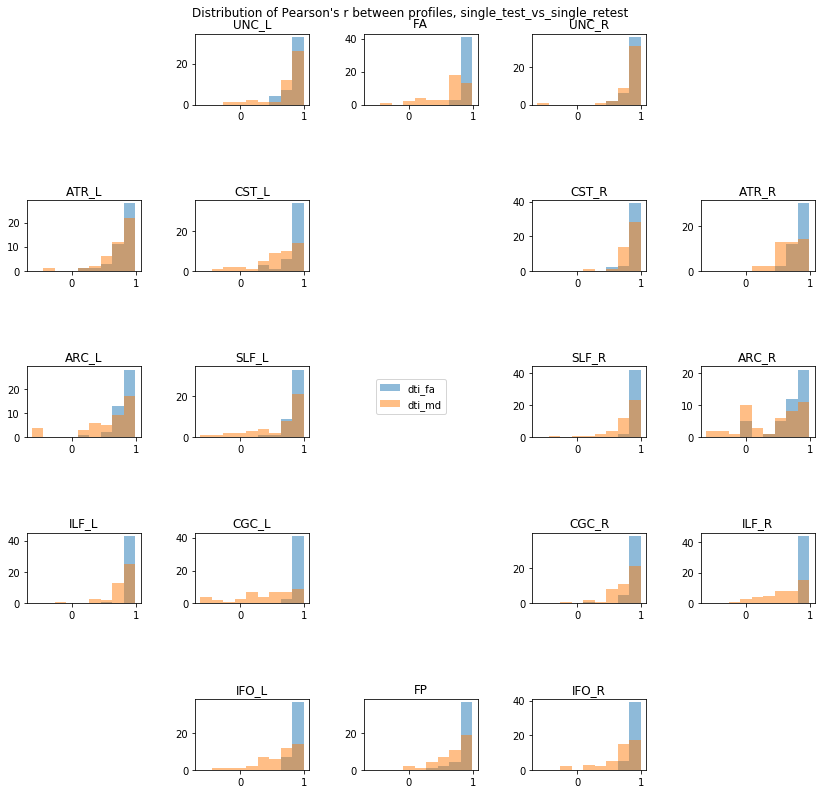

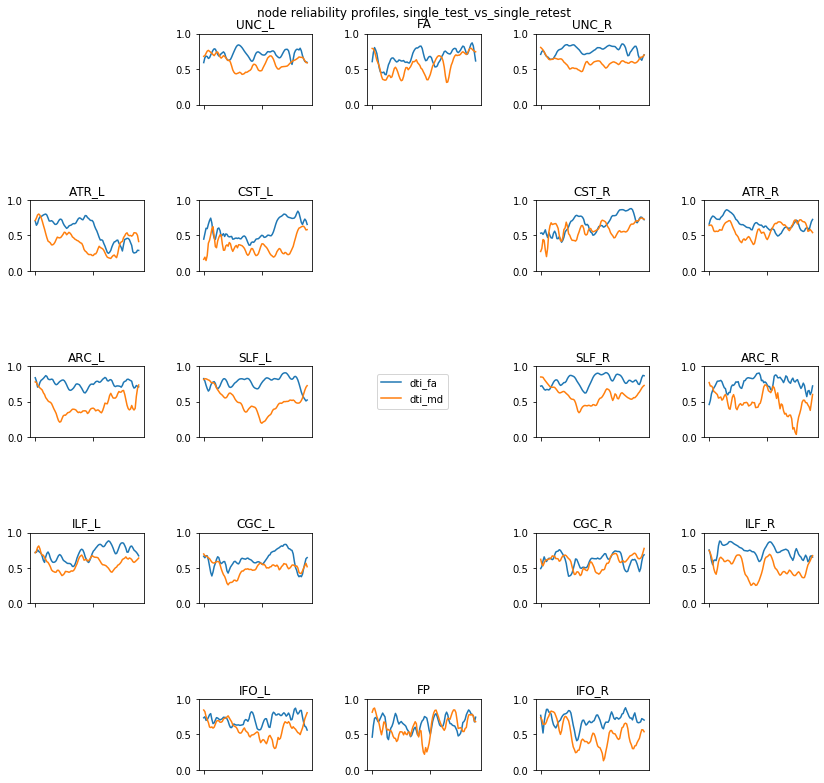

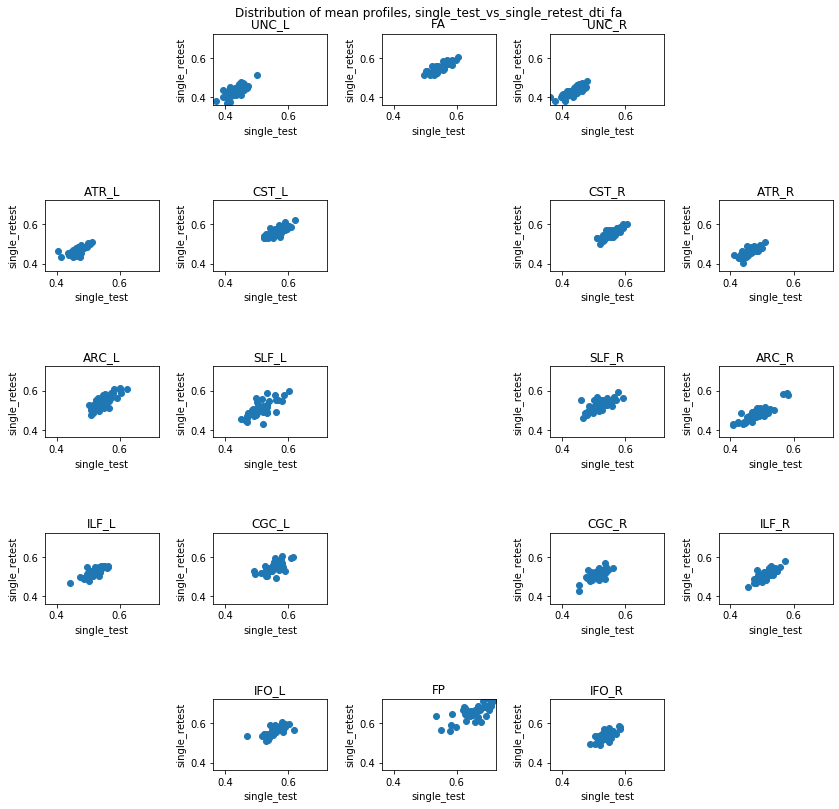

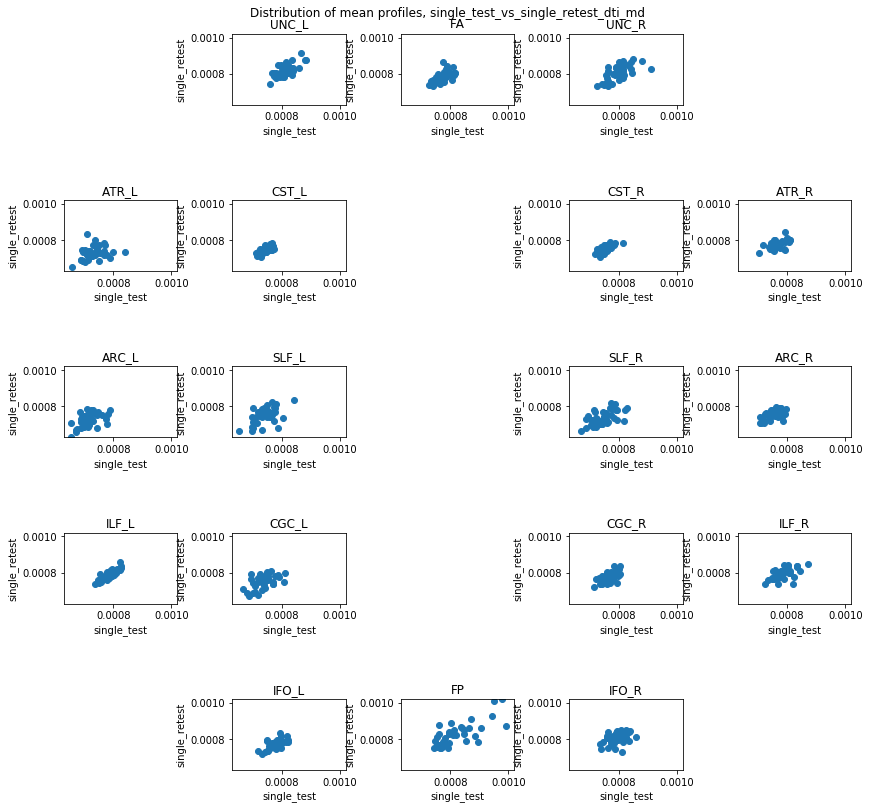

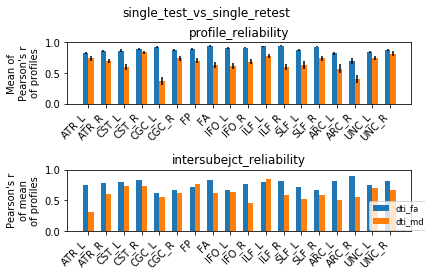

In [18]:
#single_comparisons.reliability_plots(names=['single_test', 'single_test_reco'], show_plots=True)
#single_comparisons.reliability_plots(names=['single_retest', 'single_retest_reco'], show_plots=True)
single_comparisons.reliability_plots(names=['single_test', 'single_retest'], show_plots=True)
#single_comparisons.reliability_plots(names=['single_test_reco', 'single_retest_reco'], show_plots=True)

/home/john/pyAFQ/AFQ/viz/utils.py:937: RuntimeWarning: Mean of empty slice
  all_sub_means[m, k] = np.nanmean(bundle_profiles, axis=2)


(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff60ca70550>,
       dtype=object))

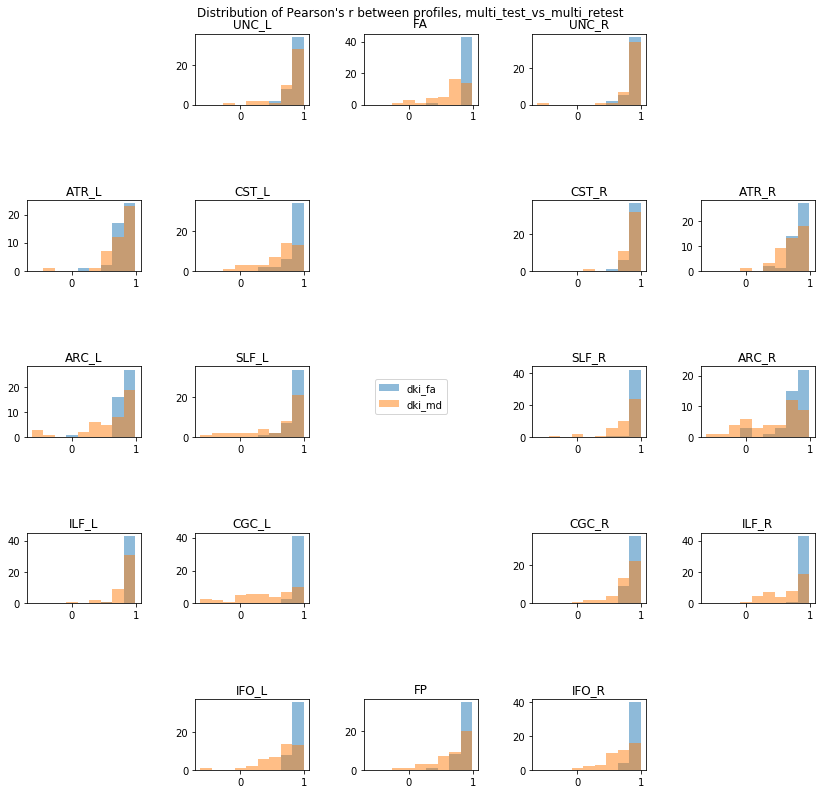

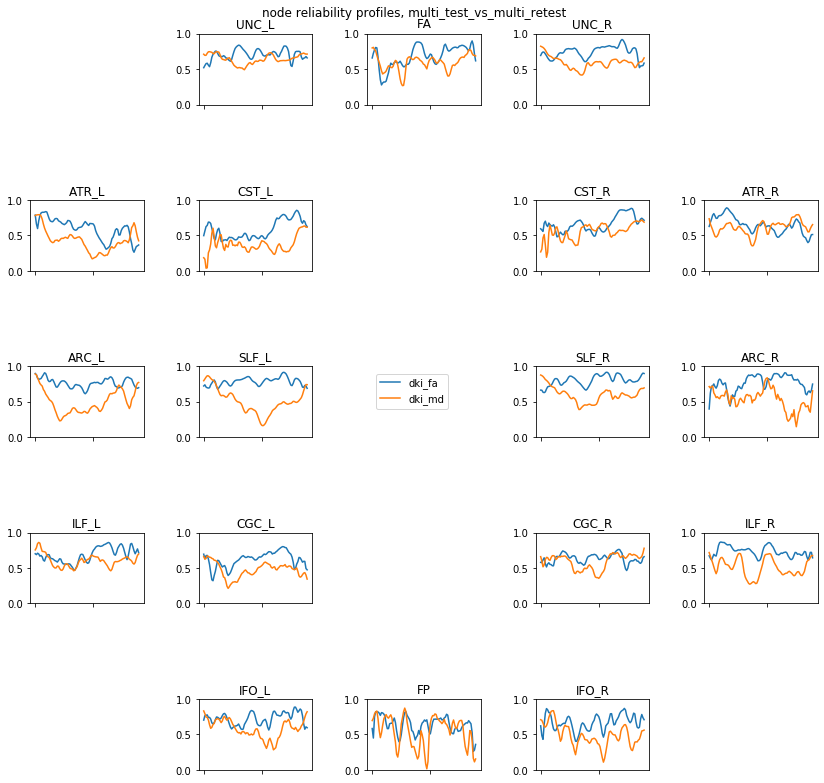

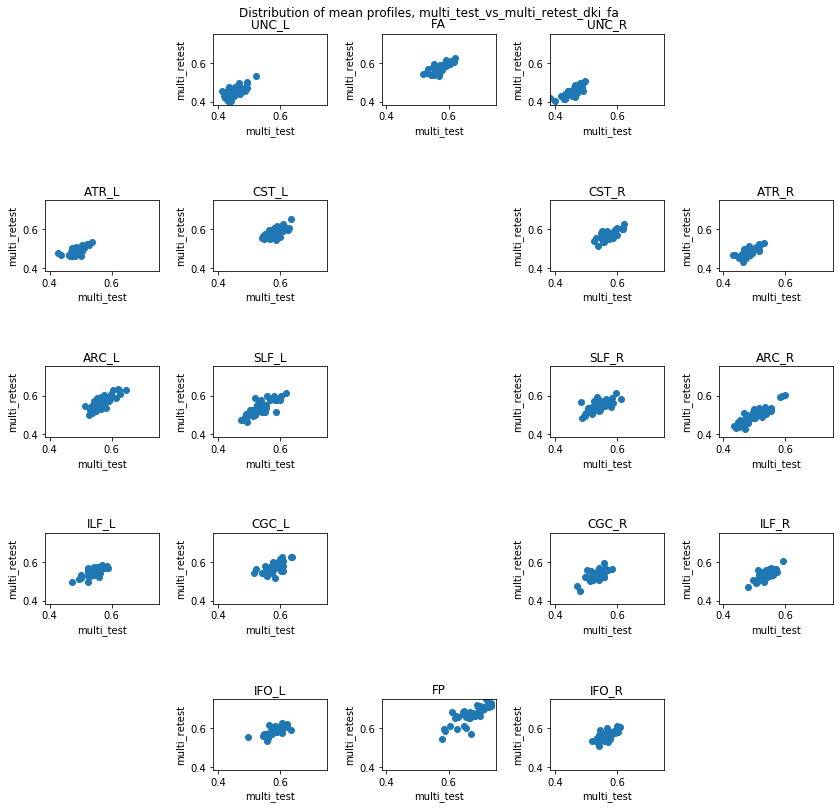

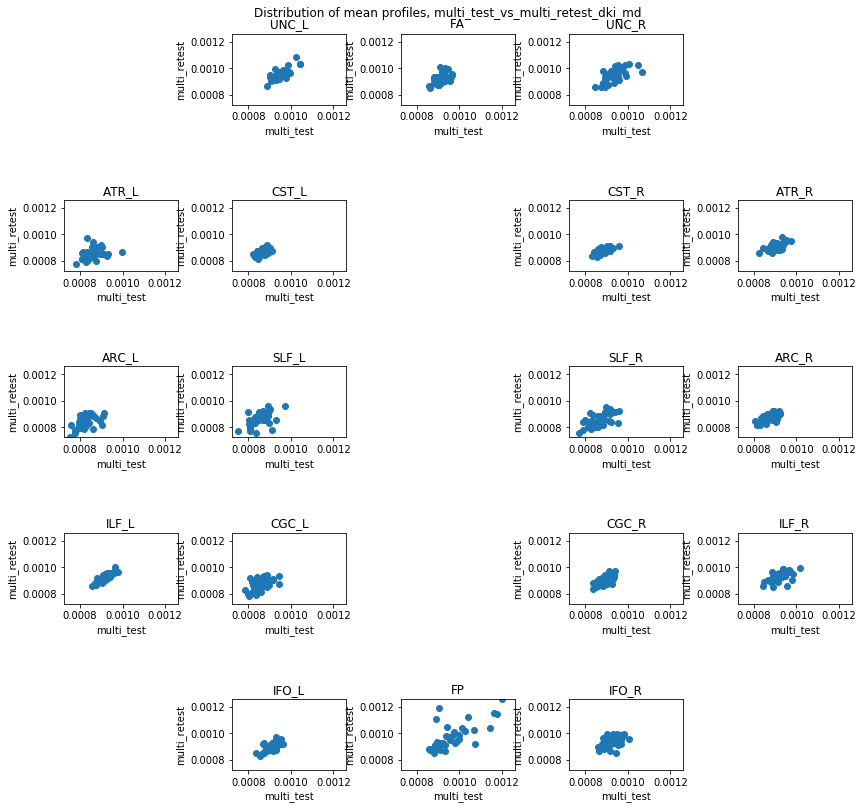

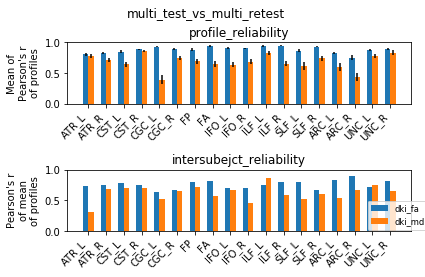

In [19]:
multi_comparisons.reliability_plots(names=['multi_test', 'multi_retest'], scalars=["dki_fa", "dki_md"], show_plots=True)